In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
ls ./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/

 classes.json  'Tile 2'/  'Tile 4'/  'Tile 6'/  'Tile 8'/
'Tile 1'/      'Tile 3'/  'Tile 5'/  'Tile 7'/


In [36]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [37]:
os.listdir("./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/Tile 1/images")

['image_part_002.jpg',
 'image_part_003.jpg',
 'image_part_004.jpg',
 'image_part_007.jpg',
 'image_part_008.jpg',
 'image_part_006.jpg',
 'image_part_001.jpg',
 'image_part_009.jpg',
 'image_part_005.jpg']

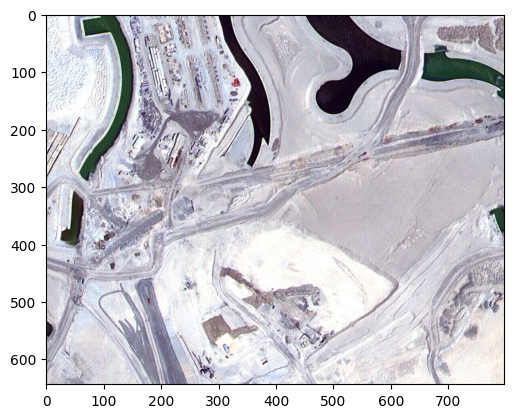

In [38]:
img1 = Image.open("./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/Tile 1/images/image_part_001.jpg").convert("RGB")
plt.imshow(img1)

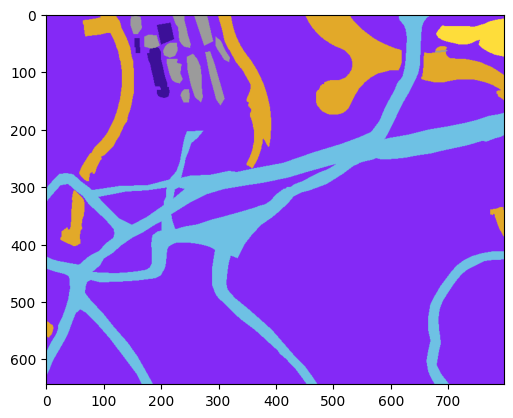

In [39]:
img2 = Image.open("./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/Tile 1/masks/image_part_001.png").convert("RGB")
plt.imshow(img2)

In [40]:
print(img1.size)

(797, 644)


In [41]:
train_paths = {
    "src": [],
    "tar": []
}
val_paths = {
    "src": [],
    "tar": []
}

total_paths = {
    "src": [],
    "tar": []
}

for i in os.listdir("./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/"):
  if i != 'classes.json':
    for j in os.listdir(f"./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/{i}/images/"):
      total_paths["src"].append(f"./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/{i}/images/{j}")
    for j in os.listdir(f"./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/{i}/masks/"):
      total_paths["tar"].append(f"./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/{i}/masks/{j}")

In [42]:
len(total_paths["src"])

72

In [43]:
def split_array_by_percentage(array):
  split_index = int(len(array) * 0.7)
  return array[:split_index], array[split_index:]

train_paths["src"], val_paths["src"] = split_array_by_percentage(total_paths["src"])
train_paths["tar"], val_paths["tar"] = split_array_by_percentage(total_paths["tar"])

print(len(train_paths["src"]), len(val_paths["src"]))

50 22


In [44]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [45]:
transform = transforms.Compose([transforms.Resize((512, 1024), interpolation=transforms.InterpolationMode.BILINEAR)])
sample = Image.open(train_paths["src"][0])
sample = transform(sample)
sample.size

(1024, 512)

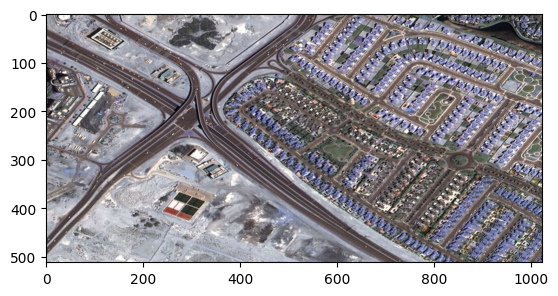

In [46]:
plt.imshow(sample)

In [47]:
sample = transforms.ToTensor()(sample)
sample.shape

torch.Size([3, 512, 1024])

In [48]:
class MapsDataset(Dataset):
    def __init__(self, src_paths, tar_paths):
        self.transforms = transforms.Compose(
            [transforms.Resize((512, 1024), interpolation=transforms.InterpolationMode.BILINEAR)])
        self.src_paths = src_paths
        self.tar_paths = tar_paths

    def __getitem__(self, idx):
        src_img = Image.open(self.src_paths[idx]).convert("RGB")
        tar_img = Image.open(self.tar_paths[idx]).convert("RGB")
        src_img = self.transforms(src_img)
        tar_img = self.transforms(tar_img)
        src_img = np.array(src_img, dtype="float32")
        tar_img = np.array(tar_img, dtype="float32")
        src_img = (src_img - 127.5) / 127.5
        tar_img = (tar_img - 127.5) / 127.5
        src_img = transforms.ToTensor()(src_img)
        tar_img = transforms.ToTensor()(tar_img)
        return {"src": src_img, "tar": tar_img}

    def __len__(self):
        return len(self.src_paths)

In [49]:
src_img = Image.open(train_paths["src"][0]).convert("RGB")
src_img = transforms.Resize(1024, interpolation=transforms.InterpolationMode.BILINEAR)(src_img)
tar_img = Image.open(train_paths["src"][0]).convert("RGB")
tar_img = transforms.Resize(1024, interpolation=transforms.InterpolationMode.BILINEAR)(tar_img)
src_img = Image.open(train_paths["src"][0]).convert("RGB")
tar_img = Image.open(train_paths["src"][0]).convert("RGB")
src_img = np.array(src_img, dtype="float32")
tar_img = np.array(tar_img, dtype="float32")
src_img = (src_img - 127.5) / 127.5
tar_img = (tar_img - 127.5) / 127.5
src_img = transforms.ToTensor()(src_img)
tar_img = transforms.ToTensor()(tar_img)
print(src_img.shape, tar_img.shape)

torch.Size([3, 846, 1099]) torch.Size([3, 846, 1099])


In [50]:
train_ds = MapsDataset(train_paths["src"], train_paths["tar"])
val_ds = MapsDataset(val_paths["src"], val_paths["tar"])

In [51]:
train_ds[0]["src"].shape

torch.Size([3, 512, 1024])

In [52]:
train_dl = DataLoader(train_ds, batch_size=1)
val_dl = DataLoader(val_ds, batch_size=1)

In [53]:
data = next(iter(train_dl))

In [54]:
torch.permute(data["src"].squeeze(), (1, 2, 0)).shape

torch.Size([512, 1024, 3])

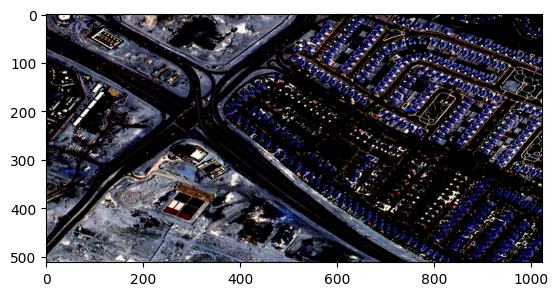

In [55]:
plt.imshow(torch.permute(data["src"].squeeze(), (1, 2, 0)))

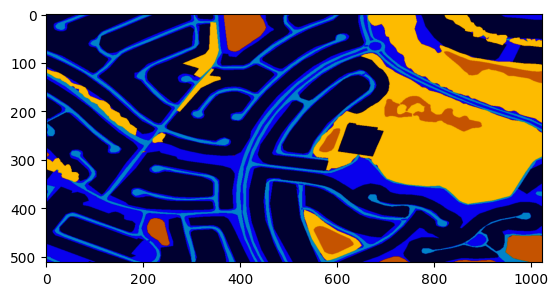

In [56]:
plt.imshow(torch.permute(data["tar"].squeeze(), (1, 2, 0)))

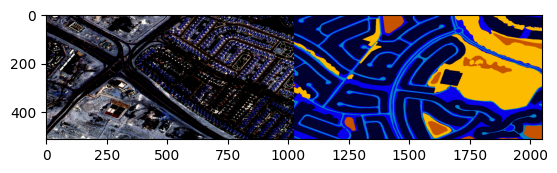

In [57]:
plt.imshow(torch.permute(torch.cat([data["src"], data["tar"]], 3).squeeze(), (1, 2, 0)))

In [58]:
from torch import nn, optim

In [59]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(6, 64, 4, stride=2)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2)
        self.conv4 = nn.Conv2d(256, 512, 4, stride=2)
        self.conv5 = nn.Conv2d(512, 512, 4, stride=1)
        self.conv6 = nn.Conv2d(512, 1, 4, stride=1)

        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(256)
        self.batch_norm3 = nn.BatchNorm2d(512)
        self.batch_norm4 = nn.BatchNorm2d(512)

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        X = self.leaky_relu(self.conv1(X))
        X = self.leaky_relu(self.batch_norm1(self.conv2(X)))
        X = self.leaky_relu(self.batch_norm2(self.conv3(X)))
        X = self.leaky_relu(self.batch_norm3(self.conv4(X)))
        X = self.leaky_relu(self.batch_norm4(self.conv5(X)))
        X = self.sigmoid(self.conv6(X))
        return X

In [60]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.d_conv1 = nn.Conv2d(3, 64, 4, stride=2, padding=1)
        self.d_conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.d_conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.d_conv4 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.d_conv5 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.d_conv6 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.d_conv7 = nn.Conv2d(512, 512, 4, stride=2, padding=1)

        self.b_conv = nn.Conv2d(512, 512, 4, stride=1, padding=1)

        self.u_conv1 = nn.ConvTranspose2d(512, 512, 4, stride=1, padding=1)
        self.u_conv2 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
        self.u_conv3 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
        self.u_conv4 = nn.ConvTranspose2d(512 * 2, 512, 4, stride=2, padding=1)
        self.u_conv5 = nn.ConvTranspose2d(512 * 2, 256, 4, stride=2, padding=1)
        self.u_conv6 = nn.ConvTranspose2d(256 * 2, 128, 4, stride=2, padding=1)
        self.u_conv7 = nn.ConvTranspose2d(128 * 2, 64, 4, stride=2, padding=1)

        self.g_conv = nn.ConvTranspose2d(64 * 2, 3, 4, stride=2, padding=1)

        self.d_batch_norm1 = nn.BatchNorm2d(128)
        self.d_batch_norm2 = nn.BatchNorm2d(256)
        self.d_batch_norm3 = nn.BatchNorm2d(512)
        self.d_batch_norm4 = nn.BatchNorm2d(512)
        self.d_batch_norm5 = nn.BatchNorm2d(512)
        self.d_batch_norm6 = nn.BatchNorm2d(512)

        self.u_batch_norm1 = nn.BatchNorm2d(512)
        self.u_batch_norm2 = nn.BatchNorm2d(512)
        self.u_batch_norm3 = nn.BatchNorm2d(512)
        self.u_batch_norm4 = nn.BatchNorm2d(512)
        self.u_batch_norm5 = nn.BatchNorm2d(256)
        self.u_batch_norm6 = nn.BatchNorm2d(128)
        self.u_batch_norm7 = nn.BatchNorm2d(64)

        self.dropout_1 = nn.Dropout(0.5)
        self.dropout_2 = nn.Dropout(0.5)
        self.dropout_3 = nn.Dropout(0.5)

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, X):
        d1 = self.leaky_relu(self.d_conv1(X))
        d2 = self.leaky_relu(self.d_batch_norm1(self.d_conv2(d1)))
        d3 = self.leaky_relu(self.d_batch_norm2(self.d_conv3(d2)))
        d4 = self.leaky_relu(self.d_batch_norm3(self.d_conv4(d3)))
        d5 = self.leaky_relu(self.d_batch_norm4(self.d_conv5(d4)))
        d6 = self.leaky_relu(self.d_batch_norm5(self.d_conv6(d5)))
        d7 = self.leaky_relu(self.d_batch_norm6(self.d_conv7(d6)))

        b = self.relu(self.b_conv(d7))

        u1 = self.relu(torch.cat([self.dropout_1(self.u_batch_norm1(self.u_conv1(b))), d7], 1))
        u2 = self.relu(torch.cat([self.dropout_2(self.u_batch_norm2(self.u_conv2(u1))), d6], 1))
        u3 = self.relu(torch.cat([self.dropout_3(self.u_batch_norm3(self.u_conv3(u2))), d5], 1))
        u4 = self.relu(torch.cat([self.u_batch_norm4(self.u_conv4(u3)), d4], 1))
        u5 = self.relu(torch.cat([self.u_batch_norm5(self.u_conv5(u4)), d3], 1))
        u6 = self.relu(torch.cat([self.u_batch_norm6(self.u_conv6(u5)), d2], 1))
        u7 = self.relu(torch.cat([self.u_batch_norm7(self.u_conv7(u6)), d1], 1))

        g = self.tanh(self.g_conv(u7))
        return g

In [61]:
class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = Generator().to(self.device)
        self.discriminator = Discriminator().to(self.device)
        self.GANcriterion = nn.BCEWithLogitsLoss().to(self.device)
        self.L1criterion = nn.L1Loss().to(self.device)
        self.opt_generator = optim.Adam(self.generator.parameters(), lr=0.001)
        self.opt_discriminator = optim.Adam(self.discriminator.parameters(), lr=0.001)

    def setup_input(self, data):
        self.src = data["src"].to(self.device)
        self.tar = data["tar"].to(self.device)

    def forward(self):
        self.generated_tar = self.generator(self.src)

    def set_requires_grad(self, model, requires_grad=True):
        for param in model.parameters():
            param.requires_grad = requires_grad

    def backward_discriminator(self):
        generated_map = torch.cat([self.src, self.generated_tar], 1)
        generated_preds = self.discriminator(generated_map.detach())
        real_map = torch.cat([self.src, self.tar], 1)
        real_preds = self.discriminator(real_map)
        loss_discriminator_generated = self.GANcriterion(generated_preds.to(self.device), torch.zeros(generated_preds.shape).to(self.device))
        loss_discriminator_real = self.GANcriterion(real_preds.to(self.device), torch.ones(real_preds.shape).to(self.device))
        loss_discriminator = (loss_discriminator_generated + loss_discriminator_real) * 0.5
        loss_discriminator.backward()

    def backward_generator(self):
        generated_map = torch.cat([self.src, self.generated_tar], 1)
        generated_preds = self.discriminator(generated_map.to(self.device))
        loss_generator_gan = self.GANcriterion(generated_preds.to(self.device), torch.ones(generated_preds.shape).to(self.device))
        loss_generator_l1 = self.L1criterion(self.generated_tar.to(self.device), self.tar.to(self.device)) * 100.0
        loss_generator = loss_generator_gan + loss_generator_l1
        loss_generator.backward()

    def optimize(self):
        self.forward()
        self.discriminator.train()
        self.set_requires_grad(self.discriminator, True)
        self.opt_discriminator.zero_grad()
        self.backward_discriminator()
        self.opt_discriminator.step()
        self.generator.train()
        self.set_requires_grad(self.discriminator, False)
        self.opt_generator.zero_grad()
        self.backward_generator()
        self.opt_generator.step()

In [62]:
import time
from tqdm.notebook import tqdm

In [63]:
model = GAN()

In [ ]:
epochs = 10

visual = next(iter(val_dl))
for e in range(epochs):
    counter = 0
    for data in tqdm(train_dl):
        model.setup_input(data)
        model.optimize()
        counter += 1
        if counter % 100 == 0:
            print(f"Epoch: {e + 1}")
            print(f"Step: {counter}/{len(train_dl)}")
            model.generator.eval()()
            with torch.no_grad():
                model.setup_input(visual)
                model.forward()
            model.generator.train()
            generated_tar = (model.generated_tar.detach() + 1) / 2.0
            real_tar = (model.tar + 1) / 2.0
            src = (model.src + 1) / 2.0
            fig = plt.figure(figsize=(15, 8))
            ax = plt.subplot(3, 1, 1)
            ax.imshow(torch.permute(src.cpu().squeeze(), (1, 2, 0)))
            ax.axis("off")
            ax = plt.subplot(3, 1, 2)
            ax.imshow(torch.permute(real_tar.cpu().squeeze(), (1, 2, 0)))
            ax.axis("off")
            ax = plt.subplot(3, 1, 3)
            ax.imshow(torch.permute(generated_tar.cpu().squeeze(), (1, 2, 0)))
            ax.axis("off")
            plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
model.eval()

In [ ]:
sample = sample.unsqueeze(0).to(model.device)
model.generator.eval()
with torch.no_grad():
  generated_img = model.generator(sample)

In [ ]:
plt.imshow(torch.permute(sample.cpu().squeeze(), (1, 2, 0)))
plt.axis("off")
plt.title("Sample Image")
plt.show()

In [ ]:
generated_img = (generated_img.detach() + 1) / 2.0
plt.imshow(torch.permute(generated_img.cpu().squeeze(), (1, 2, 0)))
plt.axis("off")
plt.title("Generated Image")
plt.show()

In [ ]:
img1 = Image.open("./drive/MyDrive/colab-notebooks/btp/dataset/semantic-segmentation-dataset/Tile 1/images/image_part_002.jpg").convert("RGB")
plt.imshow(img1)

In [ ]:
transform = transforms.Compose([transforms.Resize((512, 1024), interpolation=transforms.InterpolationMode.BILINEAR)])
# img1 = Image.open(train_paths["src"][0])
img1 = transform(img1)
img1 = transforms.ToTensor()(img1)
img1 = img1.unsqueeze(0).to(model.device)
model.generator.eval()
with torch.no_grad():
  generated_img1 = model.generator(img1)

In [ ]:
plt.imshow(torch.permute(img1.cpu().squeeze(), (1, 2, 0)))
plt.axis("off")
plt.title("Sample Image")
plt.show()

In [ ]:
generated_img1 = (generated_img1.detach() + 1) / 2.0
plt.imshow(torch.permute(generated_img1.cpu().squeeze(), (1, 2, 0)))
plt.axis("off")
plt.title("Generated Image")
plt.show()